In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class APHomoDimer(specifications.CoiledCoil):
    """Specification for creating anti-parallel, homodimeric coiled coils."""
    
    oligomeric_state = 2
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica, zshift):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 2 helices, we have 2 values for each of these, but in this case they
        # are the same as we're making a homodimer
        self.aas = [helix_length, helix_length]
        self.major_radii = [radius, radius]
        self.major_pitches = [pitch, pitch]
        self.z_shifts = [0, zshift]
        self.phi_c_alphas = [phica, phica]
        
        # We need to set the orientation of the helices to be anti-parallel, so one
        # needs to have a +1 orientation and the other needs a -1 orientation
        self.orientations = [1, -1]

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GQLEQELAALDQEIAAAEQELAALDWQIQG', 'GQLEQELAALDQEIAAAEQELAALDWQIQG']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [7]:
parameters = [
    optimisation.Parameter.static('Helix Length', 30),
    optimisation.Parameter.dynamic('Radius', 5.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['b'], 27),
    optimisation.Parameter.dynamic('ZShift', 10, 10),
]

In [8]:
default_values = [x.default_value for x in parameters]
print(default_values)

[30, 5.0, 200, 102.8, 10]


Genetic Algorithm

In [9]:
opt_ga = ev_opts.GA(APHomoDimer, sequences, parameters, get_bude_total_energy)

In [10]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	54   	-783.016	31.0539	-847.612	-723.067
1  	74   	-812.107	23.3096	-866.375	-774.262
2  	49   	-825.767	19.9368	-866.375	-792.858
3  	67   	-842.391	10.4375	-866.375	-820.603
4  	74   	-851.447	5.67675	-870.37 	-841.372
5  	58   	-853.771	5.00542	-870.37 	-847.217
6  	67   	-856.928	4.73957	-871.614	-849.624
7  	72   	-858.932	4.85876	-871.759	-852.505
8  	69   	-860.17 	5.08761	-872.48 	-853.834
9  	68   	-864.118	5.31679	-872.57 	-857.122
10 	66   	-868.279	4.10262	-872.977	-860.539
11 	66   	-871.48 	1.12743	-873.056	-867.845
12 	74   	-872.376	0.504302	-873.369	-871.457
13 	81   	-872.803	0.273814	-873.432	-872.299
14 	67   	-872.999	0.208599	-873.468	-872.624
15 	85   	-873.171	0.13251 	-873.468	-872.899
16 	72   	-873.291	0.0802941	-873.468	-873.134
17 	62   	-873.352	0.0570296	-873.489	-873.259
18 	72   	-873.394	0.0480681	-873.493	-873.317
19 	84   	-873.417	0.0406573	-873.495	-873.354
20 	65   	-873.429	0.0394276	-873.523	-873.

In [11]:
optimized_model_ga = opt_ga.best_model

In [12]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-873.5456209602978

In [13]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [14]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

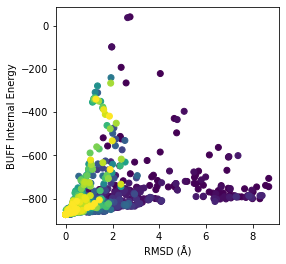

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('ga.png')

In [16]:
f = open('apCC-Di-AA_new-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

Differential Evolution

In [17]:
opt_de = ev_opts.DE(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [18]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-754.598	63.6064	-875.015	-285.957
1  	100  	-775.839	27.5051	-875.015	-703.229
2  	100  	-788.941	27.2888	-875.015	-737.207
3  	100  	-799.595	25.1192	-875.015	-737.207
4  	100  	-807.221	25.8026	-875.015	-737.207
5  	100  	-815.925	25.967 	-875.015	-737.207
6  	100  	-826.977	24.7747	-875.015	-750.811
7  	100  	-836.112	21.8642	-875.015	-750.811
8  	100  	-842.517	18.7319	-875.015	-790.402
9  	100  	-847.693	15.1908	-875.015	-801.075
10 	100  	-851.875	14.3826	-875.015	-801.075
11 	100  	-855.275	12.2254	-879.993	-811.541
12 	100  	-859.97 	9.16914	-882.492	-832.004
13 	100  	-861.947	8.63992	-882.853	-832.004
14 	100  	-863.961	7.52306	-882.853	-836.605
15 	100  	-866.588	6.45629	-882.853	-853.272
16 	100  	-868.358	7.00861	-884.904	-853.272
17 	100  	-870.148	7.21271	-884.904	-853.272
18 	100  	-872.369	7.19958	-885.398	-860.172
19 	100  	-874.178	6.98501	-885.398	-860.172
20 	100  	-877.135	6.29309	-888.918	-860.172
21 	100  	

In [19]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-890.5286065048256

In [20]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [21]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

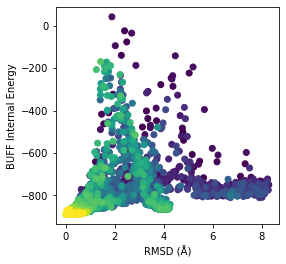

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('de.png')

In [23]:
f = open('apCC-Di-AA_new-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

Particle Swarm Optimisation

In [24]:
opt_pso = ev_opts.PSO(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [25]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-708.118	144.831	-868.117	-128.778
1  	65   	-673.88 	183.952	-869.019	-127.016
2  	64   	-667.263	172.913	-861.952	92.9195 
3  	80   	-710.802	158.238	-857.393	92.9195 
4  	71   	-749.057	97.5576	-857.306	-282.188
5  	75   	-695.141	154.778	-876.685	-181.209
6  	73   	-679.933	177.399	-876.685	-66.2402
7  	80   	-674.095	188.16 	-862.31 	-49.9074
8  	84   	-762.212	59.669 	-853.471	-440.387
9  	85   	-747.137	91.4004	-864.728	-261.15 
10 	84   	-680.753	184.202	-870.708	-51.0389
11 	76   	-595.481	236.091	-848.828	221.905 
12 	60   	-647.288	193.076	-840.423	221.905 
13 	75   	-736.992	132.574	-867.924	-51.1192
14 	55   	-738.446	134.305	-868.483	-51.1192
15 	59   	-743.757	97.2252	-867.924	-308.012
16 	71   	-667.43 	208.048	-867.924	136.768 
17 	74   	-630.26 	248.782	-875.932	165.477 
18 	57   	-660.092	213.823	-860.614	165.477 
19 	76   	-683.727	161.527	-860.614	-1.18826
20 	93   	-746.999	108.581	-860.614	-221.818
21 	93   	

In [26]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-877.011842533494

In [27]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [28]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

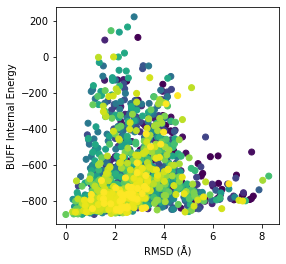

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('pso.png')

In [30]:
f = open('apCC-Di-AA_new-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

Covariance Matrix Adaptive Evolutionary Strategy

In [31]:
opt_cmaes = ev_opts.CMAES(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [32]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg    	std    	min     	max     
0  	100  	-745.13	104.881	-853.361	-282.341
1  	100  	-704.269	145.583	-881.828	-30.2448
2  	100  	-762.872	109.152	-860.851	-248.44 
3  	100  	-800.31 	70.0957	-875.994	-390.943
4  	100  	-810.47 	63.4312	-887.162	-436.775
5  	100  	-835.006	36.927 	-881.86 	-677.65 
6  	100  	-827.035	96.3088	-889.52 	-294.064
7  	100  	-852.545	27.5749	-887.033	-688.043
8  	100  	-857.418	34.2247	-886.674	-608.573
9  	100  	-866.931	30.5092	-890.416	-582.638
10 	100  	-877.416	8.43493	-889.387	-828.087
11 	100  	-880.337	6.47907	-889.434	-861.677
12 	100  	-885.62 	3.34754	-891.063	-869.473
13 	100  	-885.692	4.16429	-890.774	-866.303
14 	100  	-884.74 	6.46578	-893.075	-866.273
15 	100  	-883.432	7.27263	-892.791	-868.844
16 	100  	-886.509	5.83218	-891.514	-870.591
17 	100  	-887.099	5.34691	-892.031	-870.563
18 	100  	-884.606	7.04664	-892.531	-868.773
19 	100  	-886.096	6.24571	-893.211	-870.059
20 	100  	-884.747	7.49161	-892.755	-868.739
21 	100  	-8

In [33]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-893.2114976737445

In [34]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [35]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

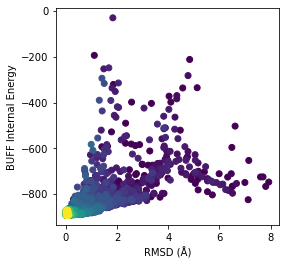

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('cmaes.png')

In [37]:
f = open('apCC-Di-AA_new-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)